In [100]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns


def simulated_response(theta, theta_tune, N,  C=1, kappa=1):
    Rmax=60
    t=1 #s
    f = np.exp(kappa*(np.cos(theta-theta_tune)-1))
    response = np.random.poisson(lam=f*Rmax*t*C, size=N)
    return response

def false_alarm_response(N):
    Rmin=10
    t=1 #s
    response = np.random.poisson(lam=Rmin*t, size=N)
    return response
    
def log_likelihood(response, theta, theta_tune, kappa=1):
    return np.dot(response, kappa*(np.cos(np.ones(np.shape(theta_tune))*theta-theta_tune)))




# Building the Likelihood

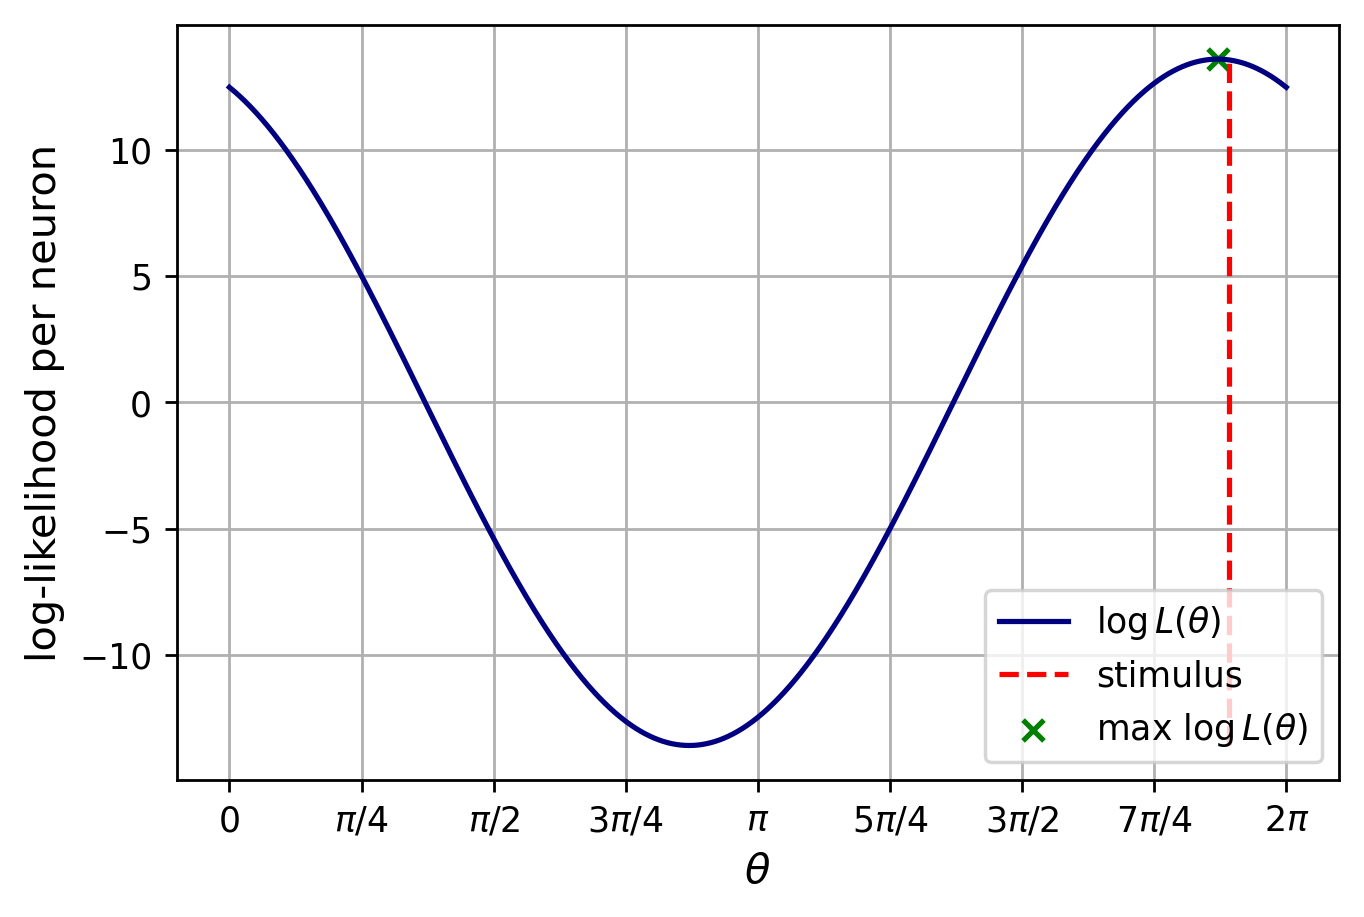

In [2]:
N = 720

theta_range = np.linspace(0, 2*np.pi, 10000)
theta_tune = np.random.choice(theta_range, size=N)

random_theta = np.random.choice(theta_range)
response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N, C=1)


full_log_likelihood=np.array([log_likelihood(response, theta=theta, theta_tune=theta_tune) for theta in theta_range])

plt.figure(dpi=250)
plt.plot(theta_range, full_log_likelihood/N, label="$\log L(\\theta)$", c="navy")
plt.vlines(x=random_theta, ymin=np.min(full_log_likelihood/N), 
                ymax=np.max(full_log_likelihood/N), color="red", 
                linestyles='dashed', label="stimulus")
plt.scatter(theta_range[np.argmax(full_log_likelihood)], 
                np.max(full_log_likelihood)/N, c="g", marker="x",
                label="max $\log L(\\theta)$")
plt.xlabel("$\\theta$", fontsize=12)
plt.ylabel("log-likelihood per neuron", fontsize=12)
plt.xticks([n*np.pi/4 for n in range(9)], labels=["0", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$", "$5\pi/4$","$3\pi/2$", "$7\pi/4$","$2\pi$"], )
plt.legend()
plt.grid()

# Behavior for different N

In [3]:
N_range=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
n_trials=1000
theta_range = np.linspace(0, 2*np.pi, 10000)

diff=np.zeros(shape=(n_trials, len(N_range)))
j=0
for N in N_range:
    i=0
    for trial in range(n_trials):
        theta_tune = np.random.choice(theta_range, size=N)
        random_theta = np.random.rand()*2*np.pi
        response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N)
        full_log_likelihood=[]
        for theta in theta_range:
            full_log_likelihood.append(log_likelihood(response, theta, theta_tune))
        diff[i][j] = np.abs(theta_range[np.argmax(full_log_likelihood)] - random_theta)
        i+=1
    j+=1
mean_diff = np.mean(diff, axis=0)
std_diff = np.std(diff, axis=0)


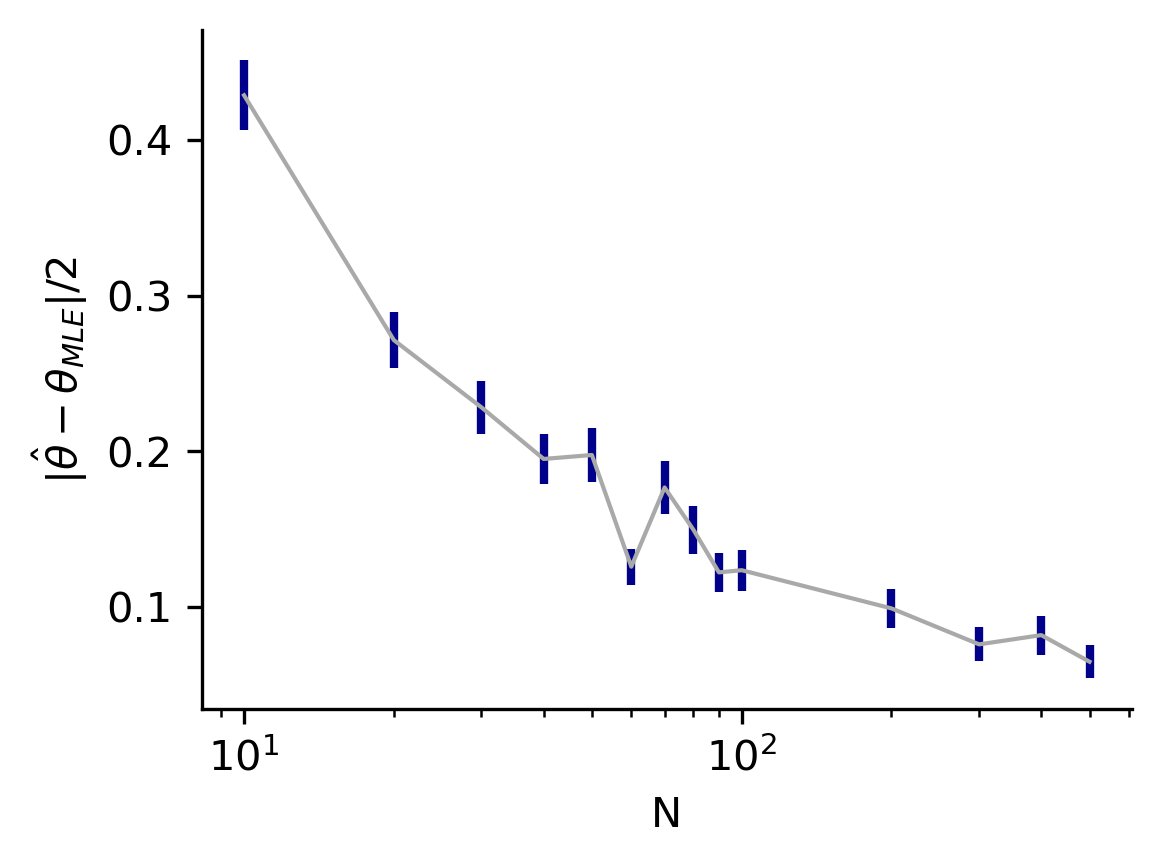

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300)
ax.errorbar(N_range, mean_diff/2, yerr=std_diff/(2*np.sqrt(n_trials)), color="darkgrey", ecolor="darkblue", linewidth=1, elinewidth=2)
#check y error normaliz factor
ax.set_xscale("log")
#plt.yscale("log")
ax.set_xlabel("N")
ax.set_ylabel("$|\hat{\\theta}-\\theta_{MLE}|/2$")
#ax.set_title("MLE error")
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.show()

# Discriminating Two Directions (for different choices of N)
criterion: difference of the log likelihood (Coherence set to 1)

In [5]:
import matplotlib.pylab as pl
colrs = pl.cm.viridis(np.linspace(0, 0.8, 3))
colrs

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.477504, 0.821444, 0.318195, 1.      ]])

In [83]:
def angle_diff(ang1, ang2):
    return np.abs((ang1-ang2) % (2*np.pi))

def accuracy(N,theta, delta_theta, n_trials, kappa=1, C=1):
    theta_range = np.linspace(0, 2*np.pi, 10000)
    theta_0 = theta_range[np.argmin(angle_diff(theta_range, theta))] #the correct angle
    theta_1 = theta_range[np.argmin(angle_diff(theta_range, theta+delta_theta))]  #angle to compare
    theta_2 = theta_range[np.argmin(angle_diff(theta_range, theta-delta_theta))]  #angle to compare
    score=[]
    for trial in range(n_trials):
        theta_tune = np.random.choice(theta_range, size=N)
        response = simulated_response(theta=theta_0, theta_tune=theta_tune , N=N, C=1)
        false_likelihood = np.max([log_likelihood(response, theta_1, theta_tune), log_likelihood(response, theta_2, theta_tune)])
        likelihood = log_likelihood(response, theta_0, theta_tune)
        score.append((likelihood>false_likelihood).astype(int))
    return np.sum(score)/n_trials


In [95]:
delta_angles= np.radians([1, 3, 5, 8, 12, 16, 22, 30, 45, 60])
N= 200
acc_vec=[]
plt.figure(dpi=250)
for delta in delta_angles:
    acc = accuracy(N, theta=2*np.pi*np.random.rand(), delta_theta=delta, n_trials=10000)
    acc_vec.append(acc)
acc_vec

[0.0614, 0.1825, 0.3011, 0.4684, 0.6451, 0.7816, 0.9116, 0.9754, 0.9993, 1.0]

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Accuracy')

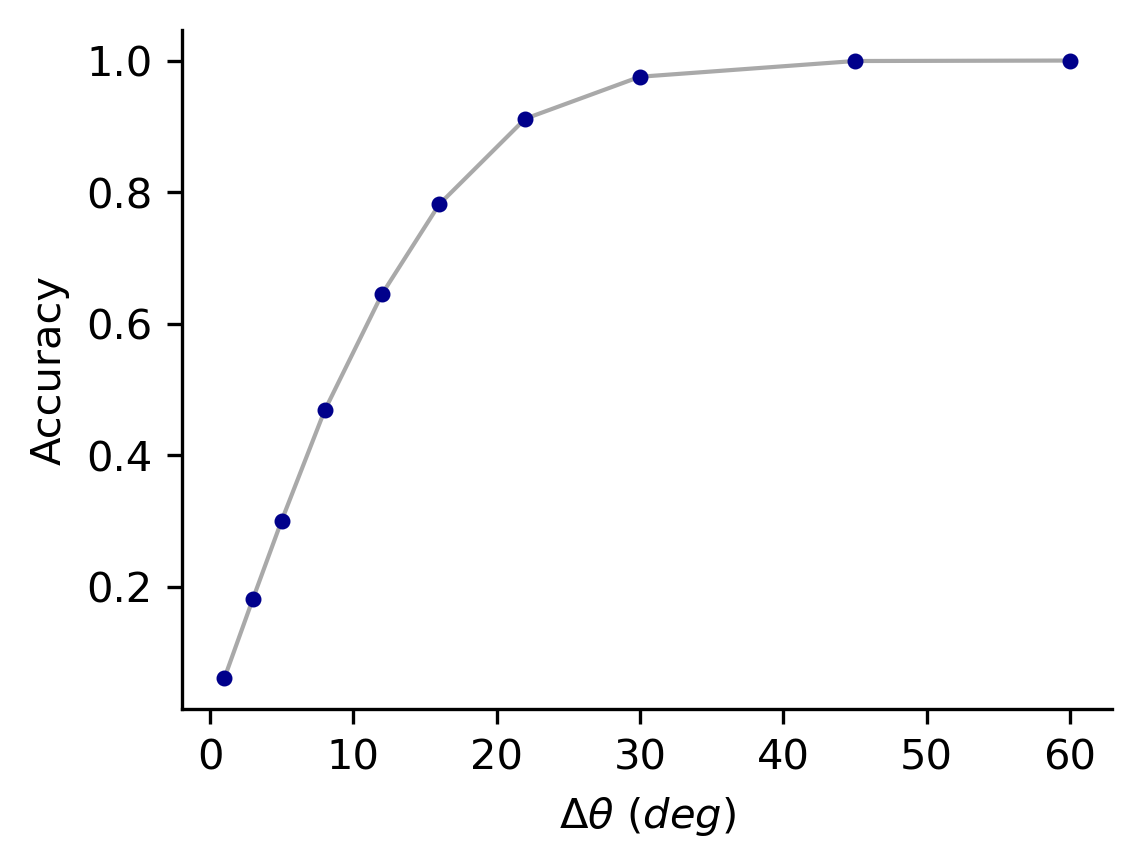

In [121]:
delta_angles = [1, 3, 5, 8, 12, 16, 22, 30, 45, 60] 
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300)

ax.plot(delta_angles, acc_vec, color="darkgrey", lw=1)
ax.scatter(delta_angles, acc_vec,  zorder=3, clip_on=False, color='darkblue', s=8)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
ax.set_xlabel("$\Delta \\theta \ (deg)$")
ax.set_ylabel("Accuracy")
#ax.set_title("Accuracy in Discrimination Task")


# Detection

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 

def simulated_response(theta, theta_tune, N,  C=1, kappa=1):
    Rmax=60
    t=1 #s
    f = np.exp(kappa*(np.cos(theta-theta_tune)-1))
    response = np.random.poisson(lam=f*Rmax*t*C, size=N)
    return response

def false_alarm_response(N):
    Rmin=10
    t=1 #s
    response = np.random.poisson(lam=Rmin*t, size=N)
    return response
    
def log_likelihood(response, theta, theta_tune, kappa=1):
    return np.dot(response, kappa*(np.cos(np.ones(np.shape(theta_tune))*theta-theta_tune)))




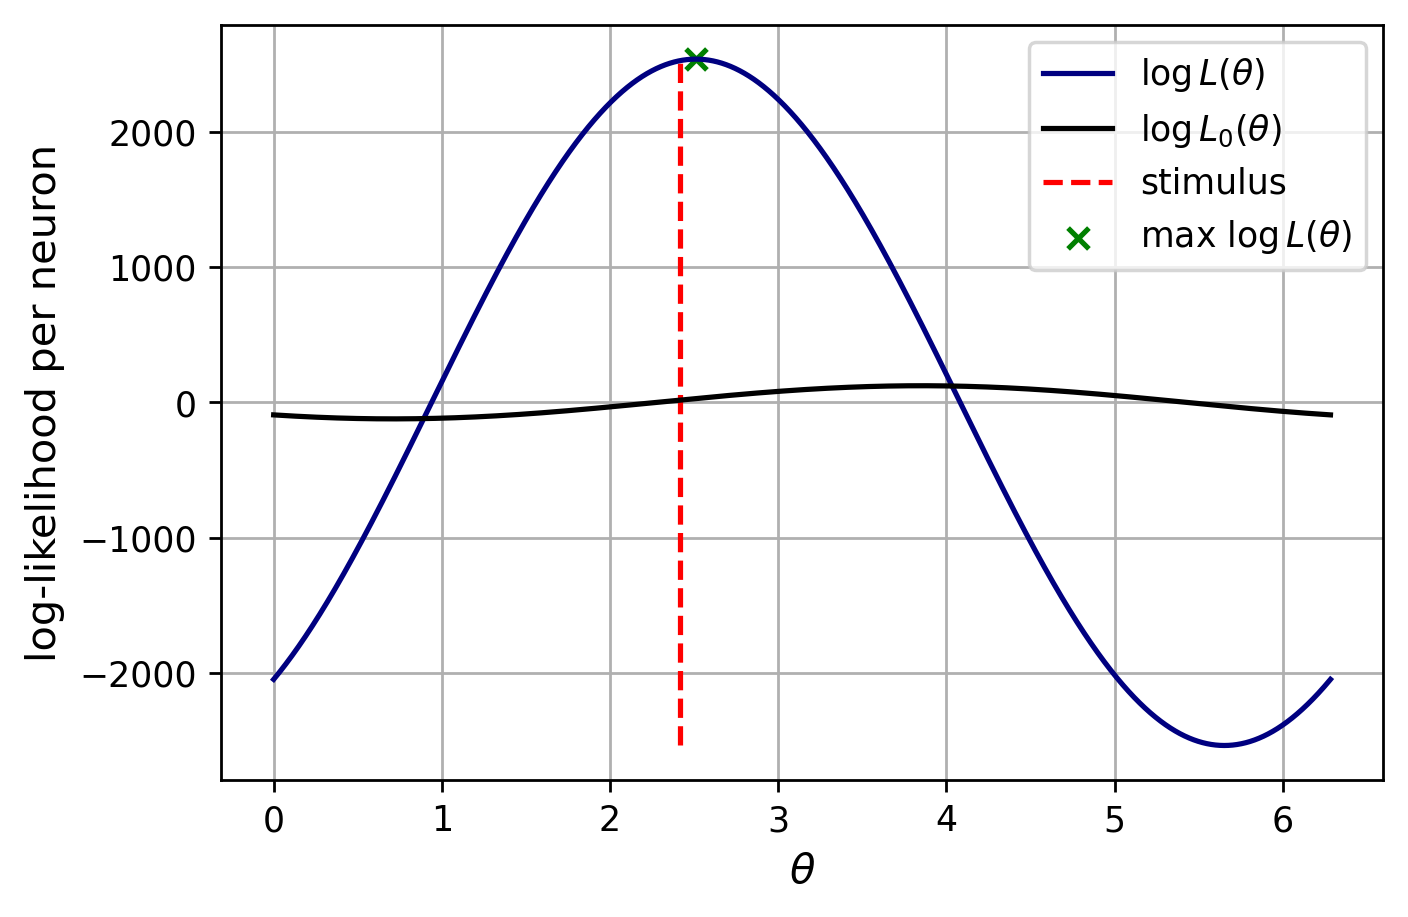

In [129]:
N=200
theta_range = np.linspace(0, 2*np.pi, 10000)
theta_tune = np.random.choice(theta_range, size=N)
random_theta = np.random.choice(theta_range)
response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N, C=1)
response_0 = false_alarm_response(N)
full_log_likelihood=[]
full_log_likelihood_0=[]

for theta in theta_range:
    full_log_likelihood.append(log_likelihood(response, theta, theta_tune))
    full_log_likelihood_0.append(log_likelihood(response_0, theta, theta_tune))

full_log_likelihood=np.array(full_log_likelihood)

plt.figure(dpi=250)
plt.plot(theta_range, full_log_likelihood, label="$\log L(\\theta)$", c="navy")
plt.plot(theta_range, full_log_likelihood_0, label="$\log L_0(\\theta)$", c="k")

plt.vlines(x=random_theta, ymin=np.min(full_log_likelihood), 
                ymax=np.max(full_log_likelihood), color="red", 
                linestyles='dashed', label="stimulus")
plt.scatter(theta_range[np.argmax(full_log_likelihood)], 
                np.max(full_log_likelihood), c="g", marker="x",
                label="max $\log L(\\theta)$")

plt.xlabel("$\\theta$", fontsize=12)
plt.ylabel("log-likelihood per neuron", fontsize=12)
plt.legend()
plt.grid()
